# Logan Wu 

## Research question/interests - Temporal Rhythms of Global Earthquakes in a 31-Day USGS Catalog

### primary interest for this EDA:
- Temporal Dynamics: Investigating the non-uniform distribution of earthquakes over the 31-day period to identify global "busy" versus "quiet" periods, and determining if activity spikes are driven by specific swarms or aftershock sequences.

- Compositional Shifts: Analyzing how the composition of earthquake magnitude and depth changes during high-activity periods compared to quiet baselines, specifically to differentiate between random fluctuations and significant mainshock releases.

- Detection Bias: Assessing potential systematic biases in the dataset, such as hourly variations in event counts (in UTC) that may reflect anthropogenic noise or sensor limitations for detecting micro-earthquakes.

In [1]:
import pandas as pd
import altair as alt
import numpy as np
alt.data_transformers.disable_max_rows()
alt.renderers.enable("png")

RendererRegistry.enable('png')

In [2]:
df = pd.read_csv('../../data/processed/ordinal_data.csv')

df.shape

(6281, 25)

# Time exploration
AQ1: How are earthquakes distributed over days and UTC hours within our 31-day snapshot, and how does the magnitude composition change (if at all) between busy and quiet periods?

In [3]:
# Basic time coverage summary
for col in ["time", "updated"]:
    df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)
    

time_summary = pd.Series({
    "n_rows": len(df),
    "n_na": df["time"].isna().sum(),
    "min_time_utc": df["time"].min(),
    "max_time_utc": df["time"].max(),
    "n_days_covered": (
        df["time"].max().floor("D") - df["time"].min().floor("D")
    ).days + 1,
    "n_unique_dates": df["time"].dt.date.nunique(),
})

print("=== Time summary ===")
print(time_summary.to_string())

=== Time summary ===
n_rows                                        6281
n_na                                             0
min_time_utc      2025-09-23 22:24:54.180000+00:00
max_time_utc      2025-10-23 22:11:40.587000+00:00
n_days_covered                                  31
n_unique_dates                                  31


In [4]:
df["date"] = df["time"].dt.floor("D")               
df["hour_utc"] = df["time"].dt.hour                 

df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magError,magNst,status,locationSource,magSource,mag_ordinal,depth_ordinal,gap_level,date,hour_utc
0,2025-10-23 22:11:40.587000+00:00,32.274000,-101.931000,4.2122,1.40,ml,40.0,40.0,0.000000,0.50,...,0.20,25.0,automatic,tx,tx,Minor (<4.0),Shallow (0-70 km),high,2025-10-23 00:00:00+00:00,22
1,2025-10-23 22:09:24.260000+00:00,38.806835,-122.751999,-0.6400,1.27,md,13.0,110.0,0.023310,0.04,...,0.21,13.0,automatic,nc,nc,Minor (<4.0),Negative (<0 km),moderate-low,2025-10-23 00:00:00+00:00,22
2,2025-10-23 22:08:01.540000+00:00,38.807835,-122.751167,0.1900,1.24,md,12.0,112.0,0.023690,0.02,...,0.21,12.0,automatic,nc,nc,Minor (<4.0),Shallow (0-70 km),moderate-low,2025-10-23 00:00:00+00:00,22
3,2025-10-23 22:07:48.630000+00:00,38.834332,-122.796333,2.2500,0.23,md,10.0,76.0,0.006201,0.02,...,0.11,10.0,automatic,nc,nc,Minor (<4.0),Shallow (0-70 km),moderate-high,2025-10-23 00:00:00+00:00,22
4,2025-10-23 22:01:31.590000+00:00,38.808998,-122.811668,3.6600,0.74,md,10.0,83.0,0.012830,0.02,...,0.07,10.0,automatic,nc,nc,Minor (<4.0),Shallow (0-70 km),moderate-high,2025-10-23 00:00:00+00:00,22


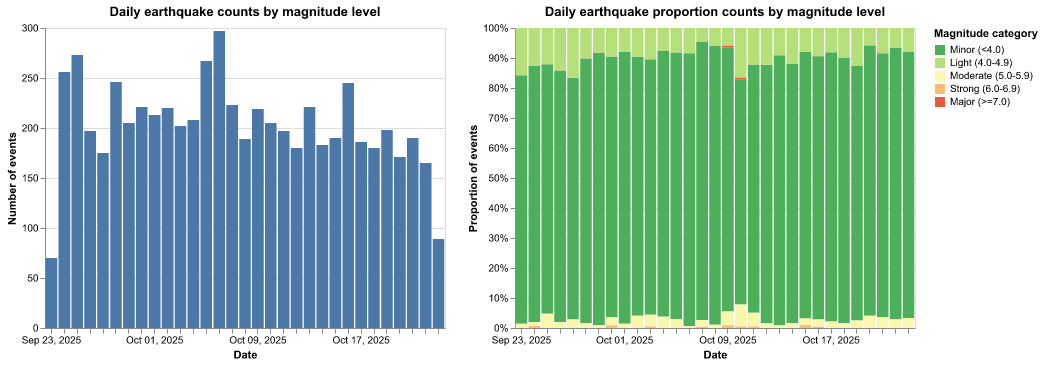

In [5]:
mag_order = [
    "Minor (<4.0)",
    "Light (4.0-4.9)",
    "Moderate (5.0-5.9)",
    "Strong (6.0-6.9)",
    "Major (>=7.0)"
]

hist_day_counts = alt.Chart(df).mark_bar().encode(
    x=alt.X('yearmonthdate(time):O', title='Date'),
    y=alt.Y("count():Q", title="Number of events")
).properties(
    title="Daily earthquake counts by magnitude level",
    width=400,
    height=300
)

hist_day_counts_proportion = alt.Chart(df).mark_bar().encode(
    x=alt.X('yearmonthdate(time):O', title='Date'),
    y=alt.Y("count():Q", stack="normalize" ,title="Proportion of events"),
    color=alt.Color("mag_ordinal:N",
                    title="Magnitude category",
                    sort=mag_order,
                    scale=alt.Scale(domain=mag_order,
                                    scheme="redyellowgreen",
                                    reverse=True))
).properties(
    title="Daily earthquake proportion counts by magnitude level",
    width=400,
    height=300
)



hist_day_counts | hist_day_counts_proportion


### Daily earthquake counts by magnitude level
This bar chart shows how many earthquakes occur on each calendar day in the 31-day catalog, with the total count on the y-axis and date on the x-axis. Daily counts fluctuate moderately, with most days between about 170 and 260 events and one clearly under-sampled partial day at the beginning of the window. This directly supports the Temporal Dynamics goal: it reveals which days can be considered globally “busy” or “quiet.” The stacked colors indicate that these busy days are mainly driven by larger numbers of Minor and Light events, not by sudden bursts of strong earthquakes.

### Daily earthquake proportion by magnitude level
The proportional bar chart keeps the same x-axis (date) but normalizes each bar to 100%, so it highlights how the magnitude composition varies over time. Across almost all days, Minor and Light events consistently account for roughly 85–95% of earthquakes, while Moderate, Strong, and Major events remain a very thin top layer. This addresses the Compositional Shifts question: even on the busiest days, the magnitude mix is remarkably stable, suggesting that high-activity periods in this month are driven by more small earthquakes rather than a structural change toward stronger mainshocks.

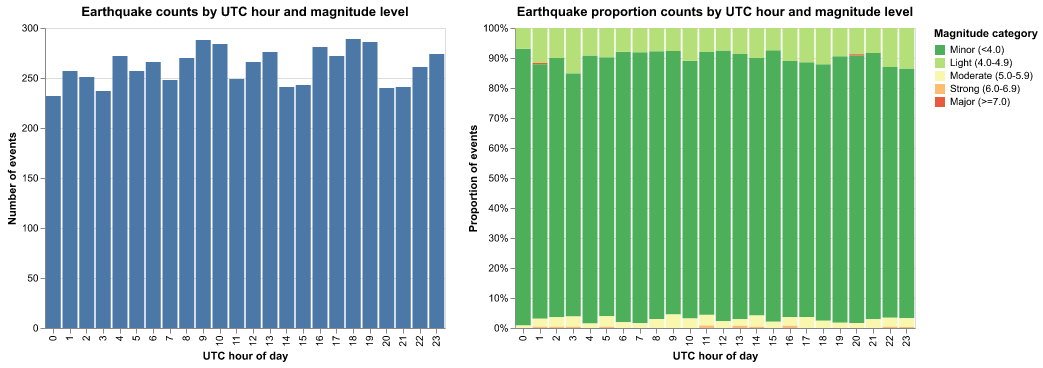

In [6]:
hist_hour_counts = alt.Chart(df).mark_bar().encode(
    x=alt.X("hour_utc:O", title="UTC hour of day"),
    y=alt.Y("count():Q", title="Number of events")
).properties(
    title="Earthquake counts by UTC hour and magnitude level",
    width=400,
    height=300
)

hist_hour_counts_proporion = alt.Chart(df).mark_bar().encode(
    x=alt.X("hour_utc:O", title="UTC hour of day"),
    y=alt.Y("count():Q", stack= 'normalize',title="Proportion of events"),
    color=alt.Color("mag_ordinal:N",
                    title="Magnitude category",
                    sort=mag_order,
                    scale=alt.Scale(domain=mag_order,
                                    scheme="redyellowgreen",
                                    reverse=True))
).properties(
    title="Earthquake proportion counts by UTC hour and magnitude level",
    width=400,
    height=300
)
hist_hour_counts | hist_hour_counts_proporion

### Earthquake counts by UTC hour and magnitude level
This bar chart aggregates the catalog by UTC hour of day. The total counts per hour are fairly flat, with all 24 hours showing similar activity levels and magnitude mixtures. From a Temporal Dynamics and Detection Bias perspective, this suggests that, at the global scale, earthquakes in UTC time do not exhibit a strong diurnal cycle—there is no clear “quiet” or “busy” band of hours. Any hourly bias due to anthropogenic noise or sensor performance is either weak or cancelled out when different local time zones are combined into a single UTC view.

### Earthquake proportion counts by UTC hour and magnitude level
The proportional version of the UTC-hour chart normalizes each bar to show the share of each magnitude category. The pattern is strikingly uniform: Minor and Light events dominate every hour, while larger events remain rare and do not cluster into specific times of day. For the Compositional Shifts interest, this indicates that hour-to-hour variations are almost entirely about how many small events occur, not about when stronger earthquakes choose to happen. For Detection Bias, it provides a baseline: we do not see obvious hours where the share of small events collapses, so any detection bias would need more targeted, region- or station-level analysis.

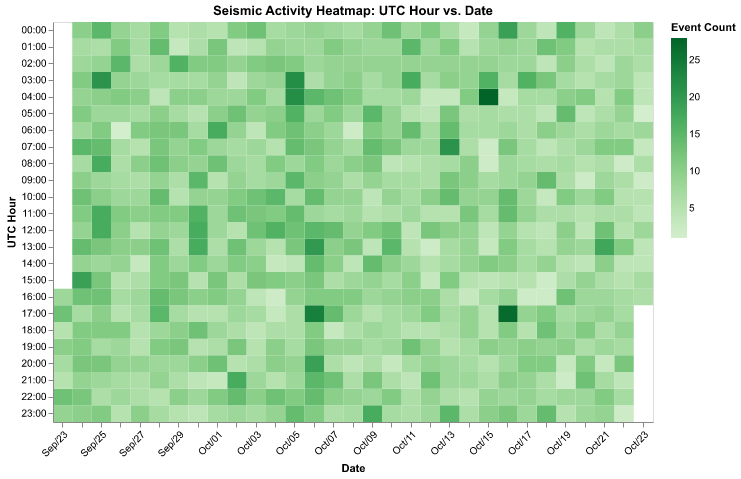

In [7]:
activity_heatmap = alt.Chart(df).mark_rect().encode(
    x=alt.X('yearmonthdate(time):O', 
            title='Date', 
            axis=alt.Axis(format='%b/%d', labelAngle=-45)),
    y=alt.Y('hours(time):O', 
            title='UTC Hour'), 
    color=alt.Color('count():Q', 
                    title='Event Count', 
                    scale=alt.Scale(scheme='greens')), 
    tooltip=[
        alt.Tooltip('yearmonthdate(time):T', title='Date', format='%b %d'),
        alt.Tooltip('hours(time):O', title='Hour'),
        alt.Tooltip('count():Q', title='Events')
    ]
).properties(
    title='Seismic Activity Heatmap: UTC Hour vs. Date',
    width=600,
    height=400
)
activity_heatmap

The heatmap with UTC hour on the y-axis and date on the x-axis provides a compact view of when earthquakes occur across the full 31-day window. The shading is fairly even both vertically (across hours) and horizontally (across most dates), with a few slightly darker columns on days that are already identified as “busy” in the daily bar chart. This directly connects to Temporal Dynamics: busy days appear as darker vertical bands, but activity is spread across many hours rather than concentrated into narrow time windows. From a Detection Bias angle, the absence of systematic horizontal stripes (i.e., no particular hour line consistently lighter or darker across all days) reinforces the idea that there is no strong, global UTC-hour bias in this catalog.

# Region

In [8]:
df["place_suffix"] = df["place"].str.split(",").str[-1].str.strip()

def assign_region(row):
    place = str(row["place"]).lower()
    suffix = str(row["place_suffix"]).lower()
    lat = row["latitude"]
    lon = row["longitude"]

    # Alaska 
    if "alaska" in place or suffix == "alaska":
        return "Alaska"

    # US West Coast: California + Washington + Oregon
    if (
        "california" in place
        or suffix == "ca"         
        or "washington" in place
        or suffix == "washington"
        or "oregon" in place
        or suffix == "oregon"
    ):
        return "US West Coast"

    # Hawaii
    if "hawaii" in place or suffix == "hawaii":
        return "Hawaii"

    # Caribbean & Puerto Rico
    if (
        "puerto rico" in place or suffix == "puerto rico"
        or "u.s. virgin islands" in place or suffix == "u.s. virgin islands"
        or "dominican republic" in place or suffix == "dominican republic"
    ):
        return "Caribbean & Puerto Rico"

    # Mexico & Central America
    if (
        "mexico" in place or suffix in ["mx", "mexico"]
        or "guatemala" in place
        or "nicaragua" in place
        or "costa rica" in place
        or "panama" in place
        or "el salvador" in place
    ):
        return "Mexico & Central America"

    # South America - Andes
    if (
        "chile" in place or suffix == "chile"
        or "peru" in place
        or "ecuador" in place
        or "argentina" in place
        or "bolivia" in place
    ):
        return "South America - Andes"

    # Japan & Kuril
    if (
        "japan" in place or suffix == "japan"
        or "kuril islands" in place
        or "hokkaido" in place
        or "honshu" in place
    ):
        return "Japan & Kuril"

    # SE Asia & SW Pacific
    if (
        "philippines" in place or suffix == "philippines"
        or "indonesia" in place or suffix == "indonesia"
        or "papua new guinea" in place or suffix == "papua new guinea"
        or "vanuatu" in place or suffix == "vanuatu"
        or "tonga" in place or suffix == "tonga"
        or "south of the fiji islands" in place
        or "timor leste" in place or suffix == "timor leste"
        or "fiji" in place
    ):
        return "SE Asia & SW Pacific"

    # Mediterranean & Europe
    if (
        "greece" in place or "turkey" in place or "italy" in place
        or "mediterranean" in place or "albania" in place
        or suffix in ["greece", "turkey", "italy"]
    ):
        return "Mediterranean & Europe"

    # US Interior / Canada all into North America - Interior
    if -130 <= lon <= -60 and 0 <= lat <= 70:
        return "North America - Interior"

    # South America other
    if -90 <= lon <= -30 and lat < 0:
        return "South America - other"

    # Europe & Africa other
    if -30 <= lon <= 60:
        return "Europe & Africa - other"

    # Asia-Pacific other
    if lon > 60 or lon < -130:
        return "Asia-Pacific - other"

    return "Other"


df["region"] = df.apply(assign_region, axis=1)

print(df["region"].value_counts())

region
US West Coast               2764
North America - Interior    1488
Alaska                       758
SE Asia & SW Pacific         284
Asia-Pacific - other         260
Mexico & Central America     217
Caribbean & Puerto Rico      163
Hawaii                       149
South America - Andes         66
Japan & Kuril                 44
Europe & Africa - other       41
Mediterranean & Europe        19
South America - other         15
Other                         13
Name: count, dtype: int64


### Region derivation

To study temporal patterns across broad tectonic areas, I created a `region` column from the raw `place`, `latitude`, and `longitude` fields. The code first extracts a `place_suffix` (the last part after the comma, e.g., “CA”, “Texas”, “Alaska”) and then uses a custom `assign_region()` function that combines text rules and coarse geographic boxes.

Concretely, events are grouped into the following regions:

- **Alaska** – any event whose place string or suffix mentions Alaska.
- **US West Coast** – events in California (including the “CA” suffix), Washington, or Oregon; this captures the main plate-boundary zone along the western U.S.
- **Hawaii** – events located in or near the Hawaiian Islands.
- **Caribbean & Puerto Rico** – events near Puerto Rico, the U.S. Virgin Islands, and the Dominican Republic.
- **Mexico & Central America** – events in Mexico (including the “MX” suffix) and along the Central American arc (Guatemala, Nicaragua, Costa Rica, Panama, El Salvador).
- **South America – Andes** – events in the subduction margin countries Chile, Peru, Ecuador, Argentina, and Bolivia.
- **Japan & Kuril** – events whose place mentions Japan, Honshu, Hokkaido, or the Kuril Islands.
- **SE Asia & SW Pacific** – events around the Philippines, Indonesia, Papua New Guinea, Vanuatu, Tonga, Fiji, Timor Leste, and nearby island arcs.
- **Mediterranean & Europe** – events in or near Greece, Turkey, Italy, the Mediterranean, and neighboring Balkan areas.
- **North America – Interior** – remaining events on the North American continent (USA/Canada) that are not West Coast or Alaska, identified using a latitude/longitude box.
- **South America – other** – non-Andean South American events.
- **Europe & Africa – other** – continental Europe and Africa outside the specific Mediterranean belt.
- **Asia-Pacific – other** – remaining events in Asia/Oceania not captured by the more specific Pacific Rim categories.
- **Other** – a small catch-all bucket for any locations that do not match the above rules.

This rule-based regionalization was designed (and iteratively refined) with the assistance of the GPT-5.1 Thinking (ChatGPT 5.1) language model, to balance geologic interpretability (major plate-boundary zones and continental interiors) with having enough events per region for meaningful temporal analysis.


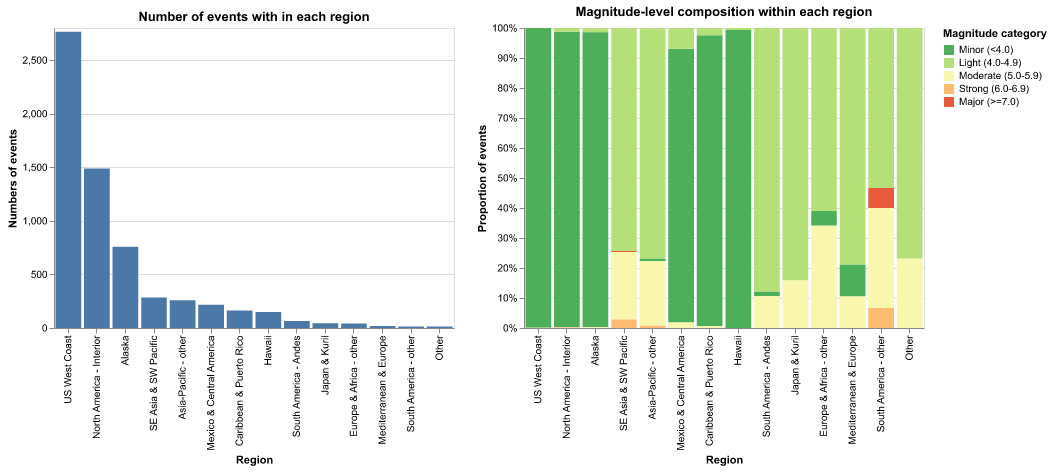

In [9]:
bubble_chart = alt.Chart(df).mark_bar().encode(
        x=alt.X("region:N", sort="-y", title="Region"),
        y=alt.Y("count():Q",title="Numbers of events"),
    ).properties(
        title="Number of events with in each region",
    width=400,
    height=300)

prop_bar = alt.Chart(df).mark_bar().encode(
    x=alt.X("region:N", sort="-y", title="Region"),
    y=alt.Y("count():Q",stack="normalize",title="Proportion of events"),
    color=alt.Color("mag_ordinal:N",
                    title="Magnitude category",
                    sort=mag_order,
                    scale=alt.Scale(domain=mag_order,
                    scheme="redyellowgreen",
                    reverse=True))
).properties(
    title="Magnitude-level composition within each region",
    width=400,
    height=300
)


bubble_chart | prop_bar


The left bar chart shows how many earthquakes occur in each region over the 31-day snapshot. The US West Coast dominates the catalog with the largest number of events, followed by the North America–Interior and Alaska, while all other regions contribute much smaller counts.

The right normalized stacked bar chart compares the magnitude composition within each region. The US West Coast, Mexico & Central America, the Caribbean, and Hawaii are overwhelmingly made up of Minor events, indicating continuous background micro-seismicity. In contrast, regions such as SE Asia & SW Pacific, South America–Andes, Europe & Africa–other, and the Mediterranean & Europe show a higher share of Light and Moderate earthquakes (and occasional Strong events), but these bars are based on much smaller sample sizes. Overall, the pair of charts suggest that high global counts are driven mainly by many small events on the US West Coast and nearby North American regions, while other tectonic belts contribute fewer but relatively stronger earthquakes.

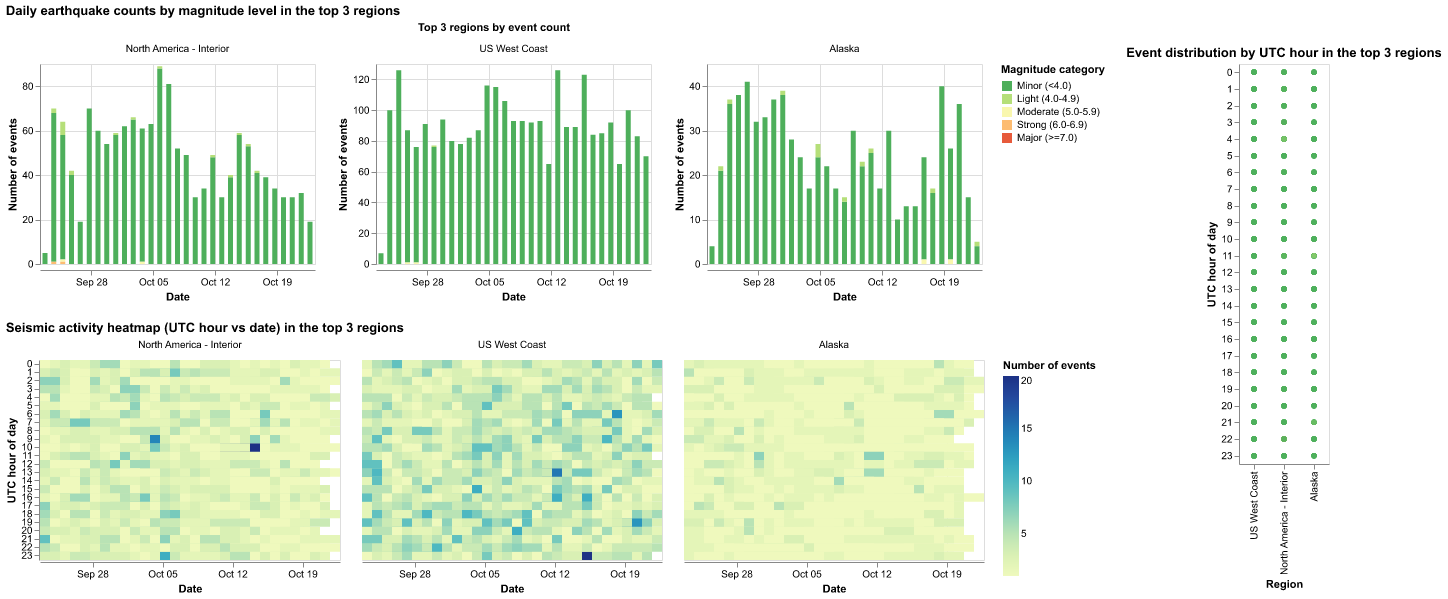

In [10]:
region_totals = (
    df.groupby("region")
      .size()
      .reset_index(name="n_events")
      .sort_values("n_events", ascending=False)
)

top3_regions = region_totals["region"].head(3).tolist()
top3_regions

chart_top3_mag = alt.Chart(df[df["region"].isin(top3_regions)]).mark_bar().encode(
    x=alt.X("date:T", title="Date"),
    y=alt.Y("count():Q", title="Number of events"),
    color=alt.Color("mag_ordinal:N",
                    title="Magnitude category",
                    sort=mag_order,
                    scale=alt.Scale(domain=mag_order,
                                    scheme="redyellowgreen",
                                    reverse=True)),
    facet=alt.Facet("region:N",
                    columns=3,
                    sort=top3_regions,
                    title="Top 3 regions by event count")
).resolve_scale(
    y="independent"
).properties(
    title="Daily earthquake counts by magnitude level in the top 3 regions",
    width=275,
    height=200
)

chart_top3_scatter = alt.Chart(df[df["region"].isin(top3_regions)]).mark_circle(size=30, opacity=0.5).encode(
    x=alt.X("region:N", sort=top3_regions, title="Region"),
    y=alt.Y("hour_utc:O", title="UTC hour of day"),
    color=alt.Color("mag_ordinal:N",
                    sort=mag_order,
                    scale=alt.Scale(
                    domain=mag_order,
                    scheme="redyellowgreen",
                    reverse=True),
                    legend=None),
    tooltip=["date:T",
             "region:N",
             "hour_utc:O",
             "mag:Q",
             "mag_ordinal:N"]
).properties(
    title="Event distribution by UTC hour in the top 3 regions",
    width=90,
    height=400
)

chart_top3_heatmap = alt.Chart(df[df["region"].isin(top3_regions)]).mark_rect().encode(
        x=alt.X("date:T", title="Date"),
        y=alt.Y("hour_utc:O", title="UTC hour of day"),
        color=alt.Color("count():Q", title="Number of events"),
        facet=alt.Facet(
            "region:N",
            columns=3,
            sort=top3_regions,
            title=None)
).properties(
    title="Seismic activity heatmap (UTC hour vs date) in the top 3 regions",
    width=300,
    height=200
)

combined = (chart_top3_mag & chart_top3_heatmap) | chart_top3_scatter

combined = combined.resolve_legend(color="shared")

combined


For the three dominant regions, the daily stacked bars show that the US West Coast has the highest and most stable activity, with 70–120 events almost every day, while the North America–Interior and Alaska have lower but more variable daily counts. In all three panels, Minor and Light events make up almost the whole bar height, so busy days are driven by more small earthquakes rather than a shift toward stronger events. The regional heatmaps (UTC hour × date) reveal only a few darker patches on specific days and hours, but no persistent horizontal bands, indicating no strong hour-of-day preference in any of the top regions. The overall scatter of events by region and UTC hour reinforces this: each of the three regions contributes events across nearly all 24 hours, with no obvious “quiet” or “forbidden” hours. Together, these views answer AQ2 by showing which regions drive global busy days (mostly the US West Coast and, to a lesser extent, the North America–Interior) and confirming that their temporal rhythms are dominated by dense swarms of small events without a clear diurnal bias.

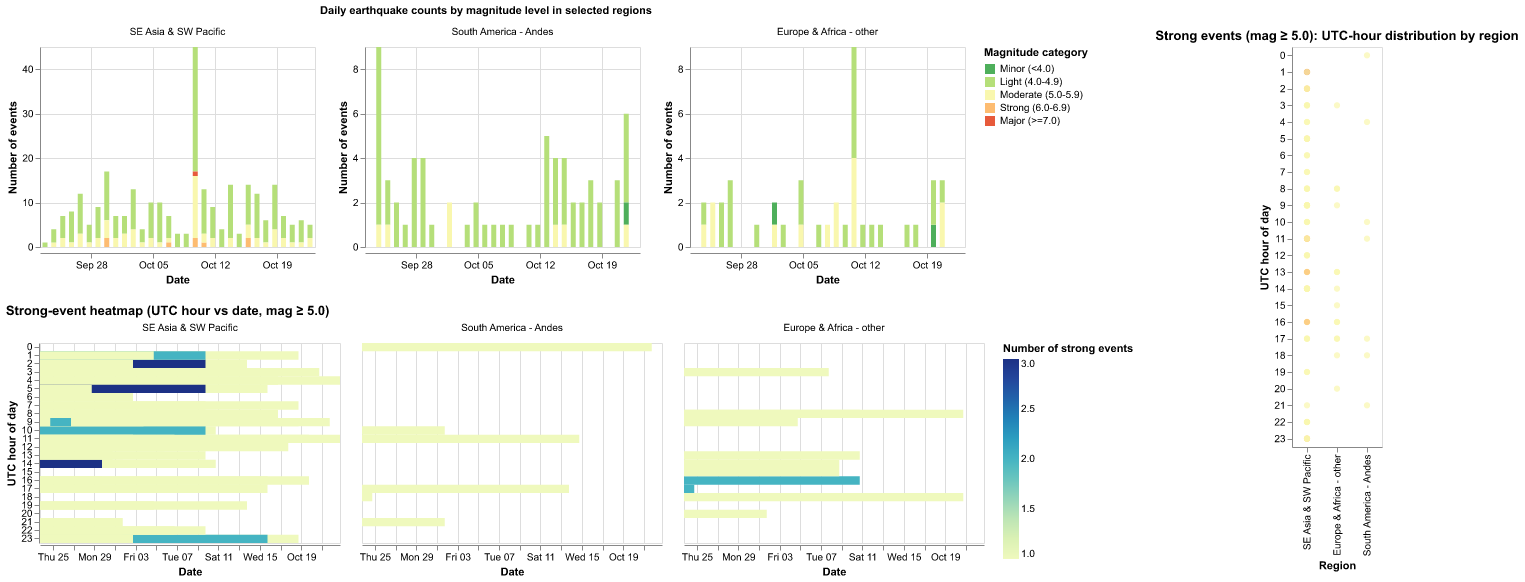

In [11]:
other_regions = ["SE Asia & SW Pacific", "Europe & Africa - other", "South America - Andes"]

chart_other3_mag = (
    alt.Chart(df[df["region"].isin(other_regions)])
    .mark_bar()
    .encode(
        x=alt.X("date:T", title="Date"),
        y=alt.Y("count():Q", title="Number of events"),
        color=alt.Color(
            "mag_ordinal:N",
            title="Magnitude category",
            sort=mag_order,
            scale=alt.Scale(
                domain=mag_order,
                scheme="redyellowgreen",
                reverse=True
            )
        ),
        facet=alt.Facet(
            "region:N",
            columns=3,
            sort=other_regions,
            title="Daily earthquake counts by magnitude level in selected regions"
        )
    )
    .resolve_scale(y="independent")
    .properties(
        width=275,
        height=200
    )
)

df_strong_other = df[(df["region"].isin(other_regions)) & (df["mag"] >= 5.0)]

chart_other3_scatter_strong = alt.Chart(df_strong_other).mark_circle(size=40, opacity=0.7).encode(
    x=alt.X("region:N", sort=other_regions, title="Region"), 
    y=alt.Y("hour_utc:O", title="UTC hour of day"), 
    color=alt.Color("mag_ordinal:N", 
                    sort=mag_order, 
                    scale=alt.Scale(domain=mag_order, 
                                    scheme="redyellowgreen", 
                                    reverse=True), 
                                    legend=None), 
    tooltip=["date:T", 
             "region:N", 
             "hour_utc:O", 
             "mag:Q", 
             "mag_ordinal:N"] 
).properties( title="Strong events (mag ≥ 5.0): UTC-hour distribution by region", width=90, height=400 )


chart_other3_heatmap_strong = alt.Chart(df_strong_other).mark_rect().encode( 
    x=alt.X("date:T", title="Date"), 
    y=alt.Y("hour_utc:O", title="UTC hour of day"), 
    color=alt.Color("count():Q", title="Number of strong events"), 
    facet=alt.Facet("region:N", columns=3, sort=other_regions, title=None) 
).properties(title="Strong-event heatmap (UTC hour vs date, mag ≥ 5.0)", 
             width=300, 
             height=200)
combined_other3 = (chart_other3_mag & chart_other3_heatmap_strong) | chart_other3_scatter_strong 
combined_other3 = combined_other3.resolve_legend(color="shared")
combined_other3

For the three additional tectonic belts, the daily stacked bars show a very different temporal pattern from the North American regions: most days are quiet with only a handful of events, punctuated by a few short bursts. Because these regions contribute a relatively high number of stronger earthquakes, we specifically focus part of the analysis on events with magnitude ≥ 5.0 to better understand their temporal behavior. In SE Asia & SW Pacific, there are several days with 10–20 events and a visible contribution from Moderate, Strong, or even Major magnitudes, while South America–Andes and Europe & Africa–other exhibit isolated peaks that likely correspond to short aftershock sequences or localized clusters. Focusing on strong events (mag ≥ 5.0), the heatmaps and the UTC-hour scatter reveal that these stronger earthquakes are sparse in time and strongly clustered: they occur on only a small set of dates and hours within each region, rather than being spread across the whole month. At the same time, there is no consistent horizontal band across regions or hours, so even for strong events we do not see a robust diurnal pattern in UTC. Together, these visuals refine the regional story from AQ2: non-North-American belts contribute relatively few but stronger earthquakes, and their strong events appear as short, localized bursts in space and time instead of driving the long, sustained “busy” periods seen on the US West Coast.

**Summary – Temporal rhythms in a 31-day global catalog**

Taken together, this EDA shows that global earthquakes in this 31-day USGS catalog have
noisy day-to-day rhythms but a very stable overall structure. Daily counts swing between
relatively “quiet” and “busy” days, yet the magnitude mix remains dominated by Minor and
Light events, with Moderate–Major earthquakes forming only a thin top layer. When we
look at UTC hour of day, both globally and within the top three regions, activity is spread
across almost all 24 hours and the magnitude composition is nearly constant, so there is no
strong evidence for a global diurnal cycle in UTC time. Regionally, the US West Coast and
the North America–Interior drive most of the busy periods through dense swarms of small
events, while tectonic belts such as SE Asia & SW Pacific, South America–Andes, and
Europe & Africa–other contribute fewer but relatively stronger earthquakes that appear as
short, localized bursts in time. Overall, the temporal rhythms in this snapshot are best
explained by fluctuations in the rate of small earthquakes in a few highly monitored
regions, rather than by global changes in the occurrence of strong events, and any remaining
detection bias is likely to be a local, network-specific effect that will need to be explored in
later stages of the project.